#IF706 - Introdução a Ciência de Dados
##Projeto 2: Modelos Preditivos
##Discente: Bruno Vinícius Gonçalves Mota
##Docente: Luciano Barbosa



###Pré-Processamento e Divisão dos Dados

In [96]:
import pandas as pd
import numpy as np

from google.colab import files
uploaded = files.upload()
import io

Saving new_store.csv to new_store (1).csv


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
pd.options.display.float_format = '{:20,.6f}'.format

Os dados escolhidos para este Projeto continuam sendo os dados de aplicativos da Google Play Store disponibilizados como datasets no Kaggle, site de competições de Data Science. Para esta etapa será tentado predizer o Rating de um app a partir das demais features.

In [98]:
#Desta vez será usado o arquivo pré-processado do Projeto anterior:
new_store = pd.read_csv(io.BytesIO(uploaded['new_store.csv']))
new_store.head()

,App,Category,Rating,Reviews,Size(M),MinimumInstalls,RangeInstalls,Type,Price($),Content Rating,Genres,Last Updated,Current Ver,Android Ver,isFamily,FamilyCategory,GameCategory,Reviews_log10,Size(M)_log10,Price($)_log10,price_reviews,price_reviews_log10,Rating_float
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.100000,159.000000,19.000000,10000,10000 - 50000,Free,0.000000,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up,0,NaN,NaN,2.201397,1.278754,-inf,0.000000,-inf,4.100000
1,Best Hairstyles step by step,BEAUTY,4.500000,"45,452.000000",9.200000,5000000,5000000 - 10000000,Free,0.000000,Everyone,Beauty,2018-07-19,1.25,4.0 and up,0,NaN,NaN,4.657553,0.963788,-inf,0.000000,-inf,4.500000
2,Bingo by IGG: Top Bingo+Slots!,GAME,4.700000,"183,343.000000",20.000000,5000000,5000000 - 10000000,Free,0.000000,Teen,Casino,2018-05-28,1.5.1,2.3 and up,0,NaN,CASINO,5.263264,1.301030,-inf,0.000000,-inf,4.700000
3,Project Fi by Google,TOOLS,4.600000,"7,342.000000",0.000000,1000000,1000000 - 5000000,Free,0.000000,Everyone,Tools,2018-07-30,Varies with device,5.1 and up,0,NaN,NaN,3.865814,-inf,-inf,0.000000,-inf,4.600000
4,Slot Machines by IGG,GAME,4.600000,"267,229.000000",24.000000,10000000,10000000 - 50000000,Free,0.000000,Teen,Casino,2018-05-28,1.7.4,2.3 and up,0,NaN,CASINO,5.426884,1.380211,-inf,0.000000,-inf,4.600000


In [99]:
#Checando os tipos:
new_store.dtypes

App                     object
Category                object
Rating                 float64
Reviews                float64
Size(M)                float64
MinimumInstalls          int64
RangeInstalls           object
Type                    object
Price($)               float64
Content Rating          object
Genres                  object
Last Updated            object
Current Ver             object
Android Ver             object
isFamily                 int64
FamilyCategory          object
GameCategory            object
Reviews_log10          float64
Size(M)_log10          float64
Price($)_log10         float64
price_reviews          float64
price_reviews_log10    float64
Rating_float           float64
dtype: object

In [0]:
#Removendo uma coluna inútil:
new_store = new_store.drop('Rating_float', axis=1)

In [101]:
#Checando a quantidade de dados que estão faltando nas colunas:
new_store.isna().sum()

App                       0
Category                  0
Rating                 1463
Reviews                   0
Size(M)                   0
MinimumInstalls           0
RangeInstalls            20
Type                      1
Price($)                  0
Content Rating            0
Genres                    0
Last Updated              0
Current Ver               8
Android Ver               2
isFamily                  0
FamilyCategory         9306
GameCategory           7833
Reviews_log10             0
Size(M)_log10             0
Price($)_log10            0
price_reviews           518
price_reviews_log10     518
dtype: int64

Percebe-se que existem valores que não poderão ser usados como nan no campo 'price_reviews'(decorrente da divisão 0/0). Os campos com tranformação logarítmica também possuem problemas com -inf. Além disso, alguns campos campos categóricos estão faltando. Para tratar os problemas dos campos númericos serão preenchidos com 0, assim pouco influenciando nos algoritmos e para os campos categóricos uma classe adicional, Undefined, será criada como alternativa. Como o campo que será de interesse predizer tem certos dados faltando estas linhas serão desconsideradas por não serem úteis para a tarefa a ser executada.

In [102]:
new_store[new_store['price_reviews'].isna()].head()

,App,Category,Rating,Reviews,Size(M),MinimumInstalls,RangeInstalls,Type,Price($),Content Rating,Genres,Last Updated,Current Ver,Android Ver,isFamily,FamilyCategory,GameCategory,Reviews_log10,Size(M)_log10,Price($)_log10,price_reviews,price_reviews_log10
27,Kick Axe Bx,HEALTH_AND_FITNESS,nan,0.000000,9.300000,1,1 - 5,Free,0.000000,Everyone,Health & Fitness,2017-06-07,1.0.1,4.0 and up,0,NaN,NaN,-inf,0.968483,-inf,nan,nan
48,BZ Langenthaler Tagblatt E-Paper,NEWS_AND_MAGAZINES,nan,0.000000,0.000000,10,10 - 50,Free,0.000000,Everyone,News & Magazines,2018-07-30,5.1.1,4.1 and up,0,NaN,NaN,-inf,-inf,-inf,nan,nan
50,Dragon B.Z Wallpapers,PERSONALIZATION,nan,0.000000,3.800000,10,10 - 50,Free,0.000000,Everyone,Personalization,2018-05-06,2.1,4.0.3 and up,0,NaN,NaN,-inf,0.579784,-inf,nan,nan
65,Learn SAP BW on HANA,BOOKS_AND_REFERENCE,nan,0.000000,13.000000,500,500 - 1000,Free,0.000000,Everyone,Books & Reference,2018-02-13,1.1,4.0 and up,0,NaN,NaN,-inf,1.113943,-inf,nan,nan
67,BW SmartLife,TOOLS,nan,0.000000,8.800000,100,100 - 500,Free,0.000000,Everyone,Tools,2017-12-05,1.1.8,4.1 and up,0,NaN,NaN,-inf,0.944483,-inf,nan,nan


In [0]:
#Removendo linhas sem Rating(valor alvo):
new_store = new_store.dropna(subset=['Rating'])

In [0]:
#Pré-processando estes campos com valores possíveis para criação de modelos
new_store.loc[new_store['RangeInstalls'].isna(), ['RangeInstalls']] = '1000000000+'
new_store.loc[new_store['Current Ver'].isna(), ['Current Ver']] = 'Undefined'
new_store.loc[new_store['Android Ver'].isna(), ['Android Ver']] = 'Undefined'
new_store.loc[new_store['price_reviews'].isna(), ['price_reviews']] = 0
new_store.loc[new_store['price_reviews_log10'].isna(), ['price_reviews_log10']] = 0

Para os campos FamilyCategory e GameCategory semelhante ao que foi feito em cima foram criados outros campos 'NO FAMILY' e 'NO GAME' para os apps que de fato não pertencem a essas classificações.

In [0]:
new_store.loc[new_store['FamilyCategory'].isna(), ['FamilyCategory']] = 'NO FAMILY'
new_store.loc[new_store['GameCategory'].isna(), ['GameCategory']] = 'NO GAME'

As transformações logarítmicas geram -inf então serão preenchidas com 0.

In [0]:
new_store.loc[new_store['Reviews_log10'] == -np.inf, ['Reviews_log10']] = 0
new_store.loc[new_store['Size(M)_log10'] == -np.inf, ['Size(M)_log10']] = 0
new_store.loc[new_store['Price($)_log10'] == -np.inf, ['Price($)_log10']] = 0
new_store.loc[new_store['price_reviews_log10'] == -np.inf, ['price_reviews_log10']] = 0

In [0]:
from sklearn.model_selection import train_test_split

Será começado a ser montado o DataFrame usado para a tarefa. As colunas abaixo não serão usadas. App, por exemplo, é o nome da Aplicação enquanto Genres foi dividido em outras colunas no pré-processamento do Projeto anterior. As outras não foram consideradas relevantes.

In [108]:
X = new_store.drop(['Rating', 'RangeInstalls', 'Genres', 'Current Ver', 
                    'Last Updated', 'App'], axis=1)
X.head(1)

,Category,Reviews,Size(M),MinimumInstalls,Type,Price($),Content Rating,Android Ver,isFamily,FamilyCategory,GameCategory,Reviews_log10,Size(M)_log10,Price($)_log10,price_reviews,price_reviews_log10
0,ART_AND_DESIGN,159.000000,19.000000,10000,Free,0.000000,Everyone,4.0.3 and up,0,NO FAMILY,NO GAME,2.201397,1.278754,0.000000,0.000000,0.000000


Agora os dados serão normalizados para estarem entre 0 e 1.

In [0]:
X['Reviews'] = (X['Reviews'] - X['Reviews'].min()) / (X['Reviews'].max() - X['Reviews'].min())
X['Size(M)'] = (X['Size(M)'] - X['Size(M)'].min()) / (X['Size(M)'].max() - X['Size(M)'].min())
X['MinimumInstalls'] = (X['MinimumInstalls'] - X['MinimumInstalls'].min()) / (X['MinimumInstalls'].max() - X['MinimumInstalls'].min())
X['Price($)'] = (X['Price($)'] - X['Price($)'].min()) / (X['Price($)'].max() - X['Price($)'].min())
X['isFamily'] = (X['isFamily'] - X['isFamily'].min()) / (X['isFamily'].max() - X['isFamily'].min())
X['Reviews_log10'] = (X['Reviews_log10'] - X['Reviews_log10'].min()) / (X['Reviews_log10'].max() - X['Reviews_log10'].min())
X['Size(M)_log10'] = (X['Size(M)_log10'] - X['Size(M)_log10'].min()) / (X['Size(M)_log10'].max() - X['Size(M)_log10'].min())
X['Price($)_log10'] = (X['Price($)_log10'] - X['Price($)_log10'].min()) / (X['Price($)_log10'].max() - X['Price($)_log10'].min())                                                                        
X['price_reviews'] = (X['price_reviews'] - X['price_reviews'].min()) / (X['price_reviews'].max() - X['price_reviews'].min())                                                                        
X['price_reviews_log10'] = (X['price_reviews_log10'] - X['price_reviews_log10'].min()) / (X['price_reviews_log10'].max() - X['price_reviews_log10'].min())                                                                        

In [110]:
X.head(1)

,Category,Reviews,Size(M),MinimumInstalls,Type,Price($),Content Rating,Android Ver,isFamily,FamilyCategory,GameCategory,Reviews_log10,Size(M)_log10,Price($)_log10,price_reviews,price_reviews_log10
0,ART_AND_DESIGN,0.000002,0.190000,0.000010,Free,0.000000,Everyone,4.0.3 and up,0.000000,NO FAMILY,NO GAME,0.278909,0.822815,0.001675,0.000000,0.754827


Convertendo as features categóricas para variáveis dummies. Em seguida são removidas as versões originais e o DataFrame ficará todo numérico.

In [111]:
category_dummies = pd.get_dummies(X['Category'], prefix='CATEGORY')
type_dummies = pd.get_dummies(X['Type'], prefix='TYPE')
content_dummies = pd.get_dummies(X['Content Rating'], prefix='CONTENT_RATING')
android_dummies = pd.get_dummies(X['Android Ver'], prefix='ANDROID_VER')
family_dummies = pd.get_dummies(X['FamilyCategory'], prefix='FAMILY_CATEGORY')
game_dummies = pd.get_dummies(X['GameCategory'], prefix='GAME_CATEGORY')
X = pd.concat([X, category_dummies, type_dummies,content_dummies, android_dummies,
              family_dummies, game_dummies], axis=1)
X = X.drop(['Category', 'Type', 'Content Rating', 'Android Ver', 'FamilyCategory', 
            'GameCategory'], axis=1)
X.head(1)

,Reviews,Size(M),MinimumInstalls,Price($),isFamily,Reviews_log10,Size(M)_log10,Price($)_log10,price_reviews,price_reviews_log10,CATEGORY_ART_AND_DESIGN,CATEGORY_AUTO_AND_VEHICLES,CATEGORY_BEAUTY,CATEGORY_BOOKS_AND_REFERENCE,CATEGORY_BUSINESS,CATEGORY_COMICS,CATEGORY_COMMUNICATION,CATEGORY_DATING,CATEGORY_EDUCATION,CATEGORY_ENTERTAINMENT,CATEGORY_EVENTS,CATEGORY_FINANCE,CATEGORY_FOOD_AND_DRINK,CATEGORY_GAME,CATEGORY_HEALTH_AND_FITNESS,CATEGORY_HOUSE_AND_HOME,CATEGORY_LIBRARIES_AND_DEMO,CATEGORY_LIFESTYLE,CATEGORY_MAPS_AND_NAVIGATION,CATEGORY_MEDICAL,CATEGORY_MUSIC & AUDIO,CATEGORY_NEWS_AND_MAGAZINES,CATEGORY_PARENTING,CATEGORY_PERSONALIZATION,CATEGORY_PHOTOGRAPHY,CATEGORY_PRODUCTIVITY,CATEGORY_SHOPPING,CATEGORY_SOCIAL,CATEGORY_SPORTS,CATEGORY_TOOLS,...,ANDROID_VER_4.2 and up,ANDROID_VER_4.3 and up,ANDROID_VER_4.4 and up,ANDROID_VER_4.4W and up,ANDROID_VER_5.0 - 6.0,ANDROID_VER_5.0 - 8.0,ANDROID_VER_5.0 and up,ANDROID_VER_5.1 and up,ANDROID_VER_6.0 and up,ANDROID_VER_7.0 - 7.1.1,ANDROID_VER_7.0 and up,ANDROID_VER_7.1 and up,ANDROID_VER_8.0 and up,ANDROID_VER_Undefined,ANDROID_VER_Varies with device,FAMILY_CATEGORY_ACTION & ADVENTURE,FAMILY_CATEGORY_BRAIN GAMES,FAMILY_CATEGORY_CREATIVITY,FAMILY_CATEGORY_EDUCATION,FAMILY_CATEGORY_MUSIC & VIDEO,FAMILY_CATEGORY_NO FAMILY,FAMILY_CATEGORY_PRETEND PLAY,GAME_CATEGORY_ACTION,GAME_CATEGORY_ADVENTURE,GAME_CATEGORY_ARCADE,GAME_CATEGORY_BOARD,GAME_CATEGORY_CARD,GAME_CATEGORY_CASINO,GAME_CATEGORY_CASUAL,GAME_CATEGORY_EDUCATIONAL,GAME_CATEGORY_MUSIC,GAME_CATEGORY_NO GAME,GAME_CATEGORY_PUZZLE,GAME_CATEGORY_RACING,GAME_CATEGORY_ROLE PLAYING,GAME_CATEGORY_SIMULATION,GAME_CATEGORY_SPORTS,GAME_CATEGORY_STRATEGY,GAME_CATEGORY_TRIVIA,GAME_CATEGORY_WORD
0,0.000002,0.190000,0.000010,0.000000,0.000000,0.278909,0.822815,0.001675,0.000000,0.754827,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


Este é o campo que será de interesse predizer. O output desejado será o Rating e como é notado caracteriza por ser um valor em um intervalo contínuo onde será realizada uma tarefa de Regressão.

In [112]:
y = new_store['Rating']
y.head()

0               4.100000
1               4.500000
2               4.700000
3               4.600000
4               4.600000
Name: Rating, dtype: float64

Dividimos os datasets de treino e teste em 70% e 30% respectivamente. O conjunto de validação será utilizado na busca de hiperparâmetros(Grid/Random Search) com cross-validation.

In [0]:
#70|30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

In [114]:
print(X_train.shape,
     X_test.shape,
     y_train.shape,
     y_test.shape)

(5737, 108) (2460, 108) (5737,) (2460,)


In [117]:
#Checando o dataset após os pré-processamentos:
X_train.head(1)

,Reviews,Size(M),MinimumInstalls,Price($),isFamily,Reviews_log10,Size(M)_log10,Price($)_log10,price_reviews,price_reviews_log10,CATEGORY_ART_AND_DESIGN,CATEGORY_AUTO_AND_VEHICLES,CATEGORY_BEAUTY,CATEGORY_BOOKS_AND_REFERENCE,CATEGORY_BUSINESS,CATEGORY_COMICS,CATEGORY_COMMUNICATION,CATEGORY_DATING,CATEGORY_EDUCATION,CATEGORY_ENTERTAINMENT,CATEGORY_EVENTS,CATEGORY_FINANCE,CATEGORY_FOOD_AND_DRINK,CATEGORY_GAME,CATEGORY_HEALTH_AND_FITNESS,CATEGORY_HOUSE_AND_HOME,CATEGORY_LIBRARIES_AND_DEMO,CATEGORY_LIFESTYLE,CATEGORY_MAPS_AND_NAVIGATION,CATEGORY_MEDICAL,CATEGORY_MUSIC & AUDIO,CATEGORY_NEWS_AND_MAGAZINES,CATEGORY_PARENTING,CATEGORY_PERSONALIZATION,CATEGORY_PHOTOGRAPHY,CATEGORY_PRODUCTIVITY,CATEGORY_SHOPPING,CATEGORY_SOCIAL,CATEGORY_SPORTS,CATEGORY_TOOLS,...,ANDROID_VER_4.2 and up,ANDROID_VER_4.3 and up,ANDROID_VER_4.4 and up,ANDROID_VER_4.4W and up,ANDROID_VER_5.0 - 6.0,ANDROID_VER_5.0 - 8.0,ANDROID_VER_5.0 and up,ANDROID_VER_5.1 and up,ANDROID_VER_6.0 and up,ANDROID_VER_7.0 - 7.1.1,ANDROID_VER_7.0 and up,ANDROID_VER_7.1 and up,ANDROID_VER_8.0 and up,ANDROID_VER_Undefined,ANDROID_VER_Varies with device,FAMILY_CATEGORY_ACTION & ADVENTURE,FAMILY_CATEGORY_BRAIN GAMES,FAMILY_CATEGORY_CREATIVITY,FAMILY_CATEGORY_EDUCATION,FAMILY_CATEGORY_MUSIC & VIDEO,FAMILY_CATEGORY_NO FAMILY,FAMILY_CATEGORY_PRETEND PLAY,GAME_CATEGORY_ACTION,GAME_CATEGORY_ADVENTURE,GAME_CATEGORY_ARCADE,GAME_CATEGORY_BOARD,GAME_CATEGORY_CARD,GAME_CATEGORY_CASINO,GAME_CATEGORY_CASUAL,GAME_CATEGORY_EDUCATIONAL,GAME_CATEGORY_MUSIC,GAME_CATEGORY_NO GAME,GAME_CATEGORY_PUZZLE,GAME_CATEGORY_RACING,GAME_CATEGORY_ROLE PLAYING,GAME_CATEGORY_SIMULATION,GAME_CATEGORY_SPORTS,GAME_CATEGORY_STRATEGY,GAME_CATEGORY_TRIVIA,GAME_CATEGORY_WORD
3723,0.000000,0.034000,0.000001,0.000000,0.000000,0.120899,0.639236,0.001675,0.000000,0.754827,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


###Regressão Linear

O primeiro algoritmo a ser testado é um dos mais simples de todos: a Regressão Linear. Inicialmente serão usadas as features a princípio numéricas, em seguida também serão incrementadas as transformações logarítmicas e por fim as originalmente categóricas(convertidas para dummies).

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error

In [0]:
#https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Será usada a função abaixo para um resumo dos resultados usando diferentes métricas de desempenho para regressão. Para análise de viés e variância para simplificação só será considerado o MSE.

In [0]:
def summary_results(y_true, y_pred):
  print(f'MSE: {mean_squared_error(y_true, y_pred)}',
        f'MAE: {mean_absolute_error(y_true, y_pred)}',
        f'R^2: {r2_score(y_true, y_pred)}',
        f'MSLE: {mean_squared_log_error(y_true, y_pred)}',
        f'MAPE: {mean_absolute_percentage_error(y_true, y_pred)}',
        sep='\n')

In [0]:
#Criando a primeira Regressão Linear:
reg1 = LinearRegression()

In [122]:
#Regressão Linear só para testar com features originalmente numéricas:
reg1.fit(X_train.loc[:,['Reviews', 'Size(M)', 'MinimumInstalls', 'Price($)', 'isFamily']], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
y_pred1 = reg1.predict(X_test.loc[:, ['Reviews', 'Size(M)', 'MinimumInstalls', 'Price($)', 'isFamily']])

Para essa primeira predição temos um MAE e MSE um tanto elevados. O R^2 score indica pouca explicabilidade dos dados e o MAPE, que indica a porcentagem quanto longe estão os valores de seus outputs, em média. 

In [124]:
summary_results(y_test, y_pred1)

MSE: 0.27831534835195215
MAE: 0.3773348433287764
R^2: 0.0021124000549836985
MSLE: 0.013866859524824885
MAPE: 10.73031923292527


In [0]:
test_error1 = mean_squared_error(y_test, y_pred1)

Está sendo definido um valor target aqui de 15% para todas as análises no projeto para o cálculo de viés e variância.

In [0]:
target_error = 0.15

Observamos um alto viés talvez indicando underfitting indicando que o modelo escolhido foi muito simples para capturar a complexidade dos dados(não linearidades). É normal utilizar na Regressão Linear variáveis transformadas para melhorar o desempenho e elas serão usadas em aplicadas em log. 

In [127]:
#Calculando o viés e a variância para alvo de 15% de erro:
y_train_pred1 = reg1.predict(X_train.loc[:,['Reviews', 'Size(M)', 'MinimumInstalls', 'Price($)', 'isFamily']])
train_error1 = mean_squared_error(y_train, y_train_pred1)
print(f'Viés: {train_error1-target_error} ; Variância: {test_error1-train_error1}')

Viés: 0.14049939233589767 ; Variância: -0.012184043983945514


In [0]:
#Agora também serão usadas features com log
reg2 = LinearRegression()
reg2.fit(X_train.loc[:,['Reviews', 'Size(M)', 'MinimumInstalls', 'Price($)', 
                        'isFamily','Reviews_log10', 'Size(M)_log10', 'Price($)_log10', 
                        'price_reviews', 'price_reviews_log10']], y_train)
y_pred2 = reg2.predict(X_test.loc[:,['Reviews', 'Size(M)', 'MinimumInstalls', 'Price($)', 
                        'isFamily','Reviews_log10', 'Size(M)_log10', 'Price($)_log10', 
                        'price_reviews', 'price_reviews_log10']])

Observa-se uma melhoria ao modelo anterior mas ainda não muito significativa. Em seguida usaremos as variáveis categóricas convertidas em dummies.

In [129]:
summary_results(y_test, y_pred2)

MSE: 0.27177415616584005
MAE: 0.36919380034194427
R^2: 0.02556556068744764
MSLE: 0.013392825666617682
MAPE: 10.38095628791456


In [0]:
test_error2 = mean_squared_error(y_test, y_pred2)

Aqui o gráfico de resíduos. Percebemos que os dados não necessariamente seguem as hipóteses da Regressão Linear.

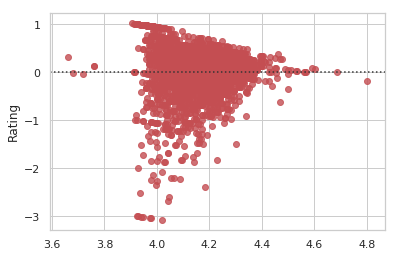

In [131]:
sns.set(style="whitegrid")
sns.residplot(y_pred2, y_test, color="r")

O viés foi reduzido significando que certas não linearidades foram capturadas desta vez que não foram na anterior.

In [132]:
#Calculando o viés e a variância para alvo de 15% de erro:
y_train_pred2 = reg2.predict(X_train.loc[:,['Reviews', 'Size(M)', 'MinimumInstalls', 
                        'Price($)', 'isFamily','Reviews_log10', 'Size(M)_log10', 
                        'Price($)_log10', 'price_reviews', 'price_reviews_log10']])
train_error2 = mean_squared_error(y_train, y_train_pred2)
print(f'Viés: {train_error2-target_error} ; Variância: {test_error2-train_error2}')

Viés: 0.12817847629083742 ; Variância: -0.006404320124997365


Nesta última Regressão todas as variáveis foram utilizadas mas ficou evidente que os erros estão bastante elevados e o R^2 está negativa indicando que este modelo não está seguindo a distribuição dos dados. Isto foi decorrente de que nesta última modelagem apareceram 3 predições negativas(com valores extremamente baixos). Podem ser feitas Seleção de Features para contornar o problema mas será optado por investigar outros métodos que façam bagging ou boosting.

MSE: 5.762371725693546e+19; R^2: -2.0660733679954166e+20; MAE: 265090222.5974936


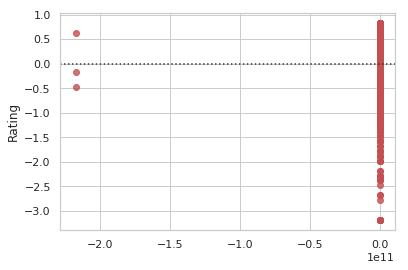

In [225]:
reg3 = LinearRegression()
reg3.fit(X_train, y_train)
y_pred3 = reg3.predict(X_test)
test_error3 = mean_squared_error(y_test, y_pred3)
print(f'MSE: {test_error3}; R^2: {r2_score(y_test, y_pred3)}; MAE: {mean_absolute_error(y_test,y_pred3)}')
sns.residplot(y_pred3, y_test, color='r')

Um viés não muito diferente dos valores acima mas uma alta variância.

In [135]:
#Calculando o viés e a variância para alvo de 15% de erro:
y_train_pred3 = reg3.predict(X_train)
train_error3 = mean_squared_error(y_train, y_train_pred3)
print(f'Viés: {train_error3-target_error} ; Variância: {test_error3-train_error3}')

Viés: 0.11233684505335503 ; Variância: 5.762371725693546e+19


###Random Forest

Agora serão realizados experimentos com Random Forest que utiliza a técnica bagging(bootstrap aggregating) a qual selecionará um subconjunto de features aleatoriamente para cada diferente estimador(decision tree) e no final usará uma regra de decisão baseada nos resultados.

In [0]:
from sklearn.ensemble import RandomForestRegressor

In [233]:
#Primeira Random Forest com 10 Decision Trees
reg1 = RandomForestRegressor(n_estimators=10, random_state=13)
reg1

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=13, verbose=0,
                      warm_start=False)

Uma curiosidade é saber as features mais importantes segundo o algoritmo em questão. Vemos que Reviews_log10 tem maior impacto seguido de MinimumInstalls e Size(M). 

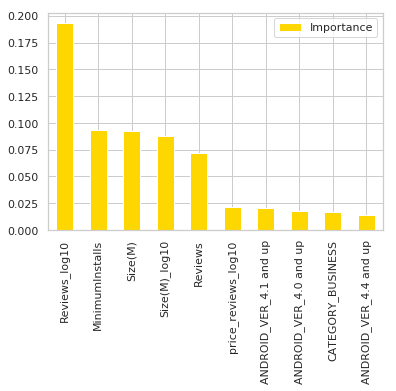

In [234]:
reg1.fit(X_train, y_train)
feat_importances = pd.DataFrame(reg1.feature_importances_, index=X.columns, 
                                columns=['Importance']).sort_values(by='Importance', 
                                                                    ascending=False)
feat_importances.head(10).plot.bar(color='gold')

As métricas estão semelhantes aos experimentos anteriores mas a variância está elevada.

In [236]:
y_pred1 = reg1.predict(X_test)
y_train_pred1 = reg1.predict(X_train)

train_error1 = mean_squared_error(y_train, y_train_pred1)
test_error1 = mean_squared_error(y_test, y_pred1)

summary_results(y_test, y_pred1)

MSE: 0.2924131571815718
MAE: 0.36152981029810305
R^2: -0.04843468152271879
MSLE: 0.01465169952506857
MAPE: 10.343752548564629


In [237]:
print(f'Viés: {train_error1-target_error} ; Variância: {test_error1-train_error1}')

Viés: -0.10139057440009296 ; Variância: 0.24380373158166474


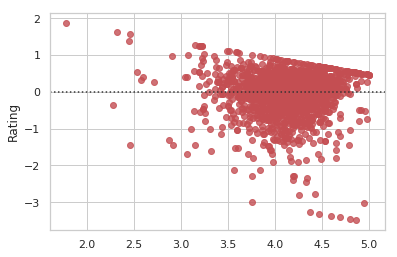

In [238]:
sns.residplot(y_pred1, y_test, color='r')

10 estimadores pode ser pouco para esse problema então agora será tentado com 100.

In [239]:
reg2 = RandomForestRegressor(n_estimators=100, random_state=13)
reg2.fit(X_train, y_train)

y_pred2 = reg2.predict(X_test)
y_train_pred2 = reg2.predict(X_train)

train_error2 = mean_squared_error(y_train, y_train_pred2)
test_error2 = mean_squared_error(y_test, y_pred2)

summary_results(y_test, y_pred2)

MSE: 0.2716447973840334
MAE: 0.349436849593496
R^2: 0.02602937098419633
MSLE: 0.013745088657708088
MAPE: 10.060820692949033


É percebida uma melhoria significativa e a variância também caiu.

In [240]:
print(f'Viés: {train_error2-target_error} ; Variância: {test_error2-train_error2}')

Viés: -0.11497723706679737 ; Variância: 0.2366220344508308


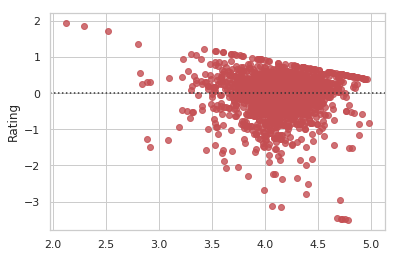

In [150]:
sns.residplot(y_pred2, y_test, color='r')

Uma busca de hiperparâmetros será realizada com Random Search para melhorar o desempenho.

In [0]:
from sklearn.model_selection import RandomizedSearchCV

In [0]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 4, 6, 8, 9, 10, 53, 70, 108],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 4, 8, 10, 12],
    'n_estimators': [200, 350, 500, 750, 1000]
}

In [242]:
reg3 = RandomForestRegressor(random_state=13)
random_search = RandomizedSearchCV(estimator = reg3, param_distributions = param_grid, 
                           cv = 5, n_jobs = -1, verbose = 0)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


É evidente a melhoria das métricas e a queda brusca do MSE e do MAPE assim como o aumento do R^2 significando resultados razoáveis. A variância segue caindo mostrando que Random Forest consegue capturar melhor os dados que uma Regressão Linear.

In [243]:
best_estimator = random_search.best_estimator_
y_pred3 = best_estimator.predict(X_test)
y_train_pred3 = best_estimator.predict(X_train)

train_error3 = mean_squared_error(y_train, y_train_pred3)
test_error3 = mean_squared_error(y_test, y_pred3)

summary_results(y_test, y_pred3)
#train_error3, test_error3, r2_score(y_pred3, y_test)

MSE: 0.2571140611802593
MAE: 0.34501033833262384
R^2: 0.07812869486870533
MSLE: 0.013038229335312934
MAPE: 9.914332714434536


In [244]:
best_estimator.get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 80,
 'max_features': 70,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 13,
 'verbose': 0,
 'warm_start': False}

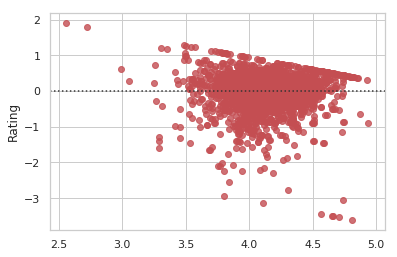

In [245]:
sns.residplot(y_pred3, y_test, color='r')

In [246]:
print(f'Viés: {train_error3-target_error} ; Variância: {test_error3-train_error3}')

Viés: -0.04038273736786427 ; Variância: 0.1474967985481236


###Gradient Boosting

Agora será tentada uma abordagem com Gradient Boosting, onde a técnica em questão, boosting, melhora otimiza as predições treinando novos estimadores baseando nos resíduos dos estimadores anteriores.

In [0]:
from sklearn.ensemble import GradientBoostingRegressor

In [248]:
reg1 = GradientBoostingRegressor(random_state=13)
reg1.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=13, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Para uma primeira vez com os parâmetros default o algoritmo não foi mal comparando com os anteriores. Aliás, isso pode indicar que ele talvez seja melhor para tarefa que Random Forest.

In [250]:
y_pred1 = reg1.predict(X_test)
y_train_pred1 = reg1.predict(X_train)

train_error1 = mean_squared_error(y_train, y_train_pred1)
test_error1 = mean_squared_error(y_test, y_pred1)

summary_results(y_test, y_pred1)

MSE: 0.2598263252822489
MAE: 0.3509919702452181
R^2: 0.06840398966944772
MSLE: 0.013214053726073842
MAPE: 10.045132896066711


As features mais importantes segundo Gradient Boosting. Com algumas leves diferenças em relação a Random Forest. Mas, também é importante notar o peso maior das 2 primeiras features em questão.

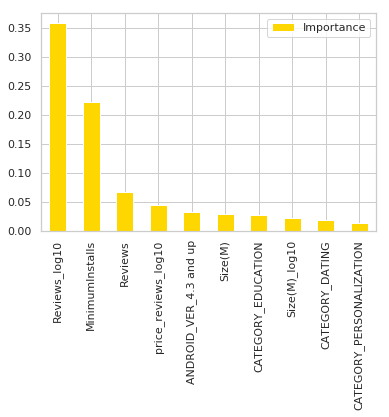

In [251]:
feat_importances = pd.DataFrame(reg1.feature_importances_, index=X.columns, 
                                columns=['Importance']).sort_values(by='Importance', 
                                                                    ascending=False)
feat_importances.head(10).plot.bar(color='gold')

Viés e Variância baixos comparados aos algoritmos anteriores. Atenção maior para Variância que conseguiu o menor resultado até agora.

In [252]:
print(f'Viés: {train_error1-target_error} ; Variância: {test_error1-train_error1}')

Viés: 0.06525393364838833 ; Variância: 0.04457239163386059


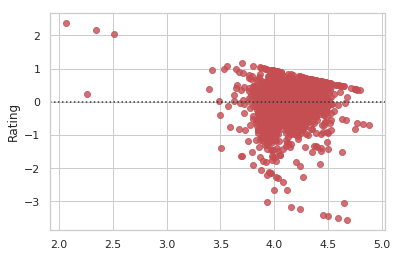

In [253]:
sns.residplot(y_pred1, y_test, color='r')

In [0]:
param_grid = {
    'n_estimators': list(range(200, 600, 50)),
    'learning_rate': [0.001, 0.005],
    'max_depth': [80, 90, 100, 110],
    'max_features': [7, 8, 9, 10],
    'min_samples_leaf': [2, 4, 6, 8, 10]
  }

Semelhante ao que foi feito com Random Search será realizada uma busca de hiperparâmetros para melhorar o desempenho.

In [256]:
reg2 = GradientBoostingRegressor(random_state=13)
random_search = RandomizedSearchCV(estimator = reg2, param_distributions = param_grid, 
                           cv = 5, n_jobs = -1, verbose = 0)
random_search.fit(X_train, y_train)

best_estimator = random_search.best_estimator_
y_pred2 = best_estimator.predict(X_test)
y_train_pred2 = best_estimator.predict(X_train)

test_error2 = mean_squared_error(y_test, y_pred2)
train_error2 = mean_squared_error(y_train, y_train_pred2)

summary_results(y_test, y_pred2)
#train_error2, test_error2, r2_score(y_test, y_pred2)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


MSE: 0.24568611971258358
MAE: 0.34180995258691443
R^2: 0.11910308291815641
MSLE: 0.012514930041964103
MAPE: 9.802665784939073


Como esperado, as métricas revelam um progresso. Abaixo percebemos que a variância aumentou um pouco mas continua em um valor aceitável. 

In [257]:
best_estimator.get_params()

{'alpha': 0.9,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.005,
 'loss': 'ls',
 'max_depth': 90,
 'max_features': 10,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 550,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': 13,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [258]:
print(f'Viés: {train_error2-target_error} ; Variância: {test_error2-train_error2}')

Viés: 0.0035967794630457905 ; Variância: 0.0920893402495378


Podemos ver abaixo que Gradient Boosting é o algoritmo que modela melhor os dados. Vemos uma boa densidade em torno das predições.

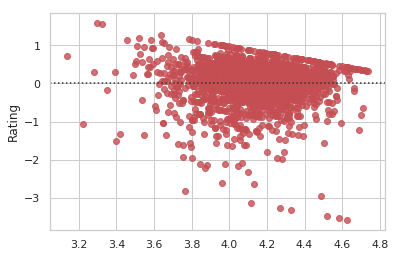

In [259]:
sns.residplot(y_pred2, y_test, color='r')

Será tentado analisar o desempenho de outras implementações como Xtreme Gradient Boosting. Logo de início ele apresenta nas métricas um desempenho levemente superior ao Gradient Boosting convencional do sklearn(sem busca de hiperparâmetros).

In [0]:
from xgboost import XGBRegressor

In [263]:
reg3 = XGBRegressor(random_state=13)
reg3.fit(X_train, y_train)

y_pred3 = reg3.predict(X_test)
y_train_pred3 = reg3.predict(X_train)

train_error3 = mean_squared_error(y_train, y_train_pred3)
test_error3 = mean_squared_error(y_test, y_pred3)

summary_results(y_test, y_pred3)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:38:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE: 0.2544236727597348
MAE: 0.34966286122314333
R^2: 0.08777496576168542
MSLE: 0.012919285302881297
MAPE: 10.005740480561846


Viés e Variância continuam com bons valores.

In [264]:
print(f'Viés: {train_error3-target_error} ; Variância: {test_error3-train_error3}')

Viés: 0.0664310420420462 ; Variância: 0.03799263071768863


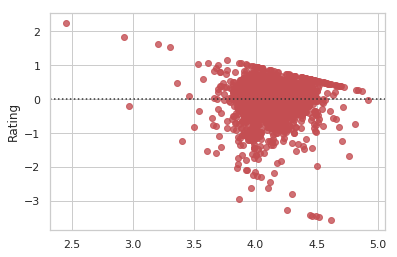

In [265]:
sns.residplot(y_pred3, y_test, color='r')

A busca de hiperparâmetros não retornou bons valores. Eles são inferiores ao Gradient Boosting e Random Forest. Além dos erros MSE e MAE altos além de R^2 negativo temos um MAPE, indicando em média  quanto longe estão os resultados dos seus outputs, de 15%. Várias dessas métricas estão piores que a Regressão Linear, que é o algoritmo mais simples. 

In [271]:
reg4 = XGBRegressor(random_state=13)
random_search2 = RandomizedSearchCV(estimator = reg4, param_distributions = param_grid, 
                           cv = 5, n_jobs = -1, verbose = 0)
random_search2.fit(X_train, y_train)

best_estimator = random_search2.best_estimator_
y_pred4 = best_estimator.predict(X_test)
y_train_pred4 = best_estimator.predict(X_train)

train_error4 = mean_squared_error(y_train, y_train_pred4)
test_error4 = mean_squared_error(y_test, y_pred4)

summary_results(y_test, y_pred4)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:48:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE: 0.5388501835678492
MAE: 0.6310548490528168
R^2: -0.932023941886498
MSLE: 0.02412374904285129
MAPE: 15.713711286325227


O viés e a variância estão consideravelmente altos tendendo para o pior caso. Logo, será optado por tentar outras alternativas. 

In [272]:
print(f'Viés: {train_error4-target_error} ; Variância: {test_error4-train_error4}')

Viés: 0.20765054599066526 ; Variância: 0.18119963757718394


Outra implementação é o Light Gradient Boosting Machine. Será checado se desempenho já com a busca de hiperparâmetros.

In [0]:
from lightgbm import LGBMRegressor

In [0]:
param_grid = {
    'n_estimators': list(range(200, 600, 100)),
    'learning_rate': [0.001, 0.005],
    'max_depth': [80, 90, 100, 110],
    'max_features': [7, 8, 9, 10],
  }

LGBM é uma implementação mais rápida e apesar de não ter o mesmo desempenho do Gradient Boosting(sklearn) consegue chegar bem perto.

In [275]:
reg5 = LGBMRegressor(random_state=13)
random_search3 = RandomizedSearchCV(estimator=reg5, param_distributions=param_grid,
                                   cv=5, n_jobs=-1, verbose=0)
random_search3.fit(X_train, y_train)

best_estimator = random_search3.best_estimator_
y_pred5 = best_estimator.predict(X_test)
y_train_pred5 = best_estimator.predict(X_train) 

train_error5 = mean_squared_error(y_train, y_train_pred5)
test_error5 = mean_squared_error(y_test, y_pred5)

summary_results(y_test, y_pred5)
#train_error5, test_error5, r2_score(y_test, y_pred5)

MSE: 0.24951786462537462
MAE: 0.3453667862738358
R^2: 0.10536452786803663
MSLE: 0.012714230992581567
MAPE: 9.901524690220281


In [276]:
best_estimator.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.005,
 'max_depth': 80,
 'max_features': 10,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 500,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 13,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

Diferente do XGB, este algoritmo não resulta em valores altos em viés e variância.

In [277]:
print(f'Viés: {train_error5-target_error} ; Variância: {test_error5-train_error5}')

Viés: 0.05584587051698128 ; Variância: 0.04367199410839334


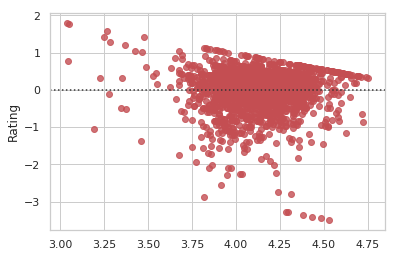

In [278]:
sns.residplot(y_pred5, y_test, color='r')

###Multi-Layer Perceptron

A seguir, serão tentadas uma série de MLP's para avaliar seu desempenho neste dataset.

In [0]:
from sklearn.neural_network import MLPRegressor

A primeira Rede Neural possui apenas uma camada com 50 neurônios e função de ativação tangente hiperbólica. A fração de validação será 25% dos dados.

In [281]:
reg1 = MLPRegressor(hidden_layer_sizes=(50,), activation='tanh', solver='adam',
                   max_iter=200, random_state=13, early_stopping=True,
                   validation_fraction=0.25, verbose=True)
reg1.fit(X_train, y_train)
y_pred1 = reg1.predict(X_test)
y_train_pred1 = reg1.predict(X_train)

train_error1 = mean_squared_error(y_train, y_train_pred1)
test_error1 = mean_squared_error(y_test, y_pred1)

#train_error1, test_error1, r2_score(y_test, y_pred1)

Iteration 1, loss = 4.85499952
Validation score: -17.510412
Iteration 2, loss = 1.31189929
Validation score: -2.427315
Iteration 3, loss = 0.26545502
Validation score: -0.230000
Iteration 4, loss = 0.17750736
Validation score: -0.193456
Iteration 5, loss = 0.17065563
Validation score: -0.134441
Iteration 6, loss = 0.16413266
Validation score: -0.096988
Iteration 7, loss = 0.15895075
Validation score: -0.065271
Iteration 8, loss = 0.15501692
Validation score: -0.040692
Iteration 9, loss = 0.15168672
Validation score: -0.021208
Iteration 10, loss = 0.14909285
Validation score: -0.006193
Iteration 11, loss = 0.14706440
Validation score: 0.005239
Iteration 12, loss = 0.14546685
Validation score: 0.014512
Iteration 13, loss = 0.14427148
Validation score: 0.021002
Iteration 14, loss = 0.14331746
Validation score: 0.026775
Iteration 15, loss = 0.14245973
Validation score: 0.030904
Iteration 16, loss = 0.14184057
Validation score: 0.033030
Iteration 17, loss = 0.14131563
Validation score: 0.03

A primeira rede apresenta resultados razoáveis mas pode ser que esteja ocorrendo underfitting levando ao teste de outras arquiteturas.

In [282]:
summary_results(y_test, y_pred1)

MSE: 0.27252260445490123
MAE: 0.36913262987929124
R^2: 0.022882031836894634
MSLE: 0.013416679018840501
MAPE: 10.378143566219505


In [283]:
print(f'Viés: {train_error1-target_error} ; Variância: {test_error1-train_error1}')

Viés: 0.1127565354164419 ; Variância: 0.009766069038459335


Será repetido o experimento porém agora a função de ativação é a ReLU.

In [284]:
reg2 = MLPRegressor(hidden_layer_sizes=(50,), activation='relu', solver='adam',
                   max_iter=200, random_state=13, early_stopping=True,
                   validation_fraction=0.25, verbose=True)
reg2.fit(X_train, y_train)

y_pred2 = reg2.predict(X_test)
y_train_pred2 = reg2.predict(X_train)

train_error2 = mean_squared_error(y_train, y_train_pred2)
test_error2 = mean_squared_error(y_test, y_pred2)

#train_error2, test_error2, r2_score(y_test, y_pred2)

Iteration 1, loss = 5.46741801
Validation score: -26.747775
Iteration 2, loss = 2.43235027
Validation score: -8.065232
Iteration 3, loss = 0.61629853
Validation score: -0.689808
Iteration 4, loss = 0.20582961
Validation score: -0.391413
Iteration 5, loss = 0.18914288
Validation score: -0.229709
Iteration 6, loss = 0.17375336
Validation score: -0.151991
Iteration 7, loss = 0.16382655
Validation score: -0.094289
Iteration 8, loss = 0.15704707
Validation score: -0.052510
Iteration 9, loss = 0.15171508
Validation score: -0.022711
Iteration 10, loss = 0.14800847
Validation score: -0.002821
Iteration 11, loss = 0.14543425
Validation score: 0.010486
Iteration 12, loss = 0.14358694
Validation score: 0.020299
Iteration 13, loss = 0.14242619
Validation score: 0.026234
Iteration 14, loss = 0.14138952
Validation score: 0.031868
Iteration 15, loss = 0.14057423
Validation score: 0.037257
Iteration 16, loss = 0.13990766
Validation score: 0.039217
Iteration 17, loss = 0.13938041
Validation score: 0.04

A ReLU aparentemente leva a resultados melhores.

In [285]:
summary_results(y_test, y_pred2)

MSE: 0.26989400660504415
MAE: 0.3671000443277644
R^2: 0.032306755321053426
MSLE: 0.013313642969030781
MAPE: 10.326076483965908


In [286]:
print(f'Viés: {train_error2-target_error} ; Variância: {test_error2-train_error2}')

Viés: 0.11067704268858455 ; Variância: 0.009216963916459597


Agora será adiciona mais uma camada oculta com 25 neurônios para rede com função de ativação tanh.

In [287]:
reg3 = MLPRegressor(hidden_layer_sizes=(50,25,), activation='tanh', solver='adam',
                   max_iter=200, random_state=13, early_stopping=True,
                   validation_fraction=0.25, verbose=True)
reg3.fit(X_train, y_train)

y_pred3 = reg3.predict(X_test)
y_train_pred3 = reg3.predict(X_train)

train_error3 = mean_squared_error(y_train, y_train_pred3)
test_error3 = mean_squared_error(y_test, y_pred3)

#train_error3, test_error3, r2_score(y_test, y_pred3)

Iteration 1, loss = 5.40918345
Validation score: -10.688977
Iteration 2, loss = 0.68354423
Validation score: -0.061315
Iteration 3, loss = 0.16440996
Validation score: -0.125763
Iteration 4, loss = 0.15570976
Validation score: 0.009806
Iteration 5, loss = 0.14787773
Validation score: 0.021446
Iteration 6, loss = 0.14539798
Validation score: 0.029565
Iteration 7, loss = 0.14370224
Validation score: 0.036763
Iteration 8, loss = 0.14205229
Validation score: 0.045701
Iteration 9, loss = 0.14062653
Validation score: 0.050320
Iteration 10, loss = 0.13931783
Validation score: 0.055917
Iteration 11, loss = 0.13827525
Validation score: 0.060237
Iteration 12, loss = 0.13731786
Validation score: 0.063594
Iteration 13, loss = 0.13650150
Validation score: 0.066890
Iteration 14, loss = 0.13583143
Validation score: 0.069591
Iteration 15, loss = 0.13516974
Validation score: 0.071426
Iteration 16, loss = 0.13474584
Validation score: 0.072402
Iteration 17, loss = 0.13416928
Validation score: 0.075168
It

O erros continam a baixar e a explicabilidade a aumentar indicando que foi uma boa escolha a adição de uma nova camada. 

In [288]:
summary_results(y_test, y_pred3)

MSE: 0.26829266184899897
MAE: 0.367929054771781
R^2: 0.038048307430043504
MSLE: 0.013203157678281098
MAPE: 10.307289895942425


In [289]:
print(f'Viés: {train_error3-target_error} ; Variância: {test_error3-train_error3}')

Viés: 0.10456061410414916 ; Variância: 0.013732047744849818


Uma nova camada com a função de ativação ReLU.

In [290]:
reg4 = MLPRegressor(hidden_layer_sizes=(50,25,), activation='relu', solver='adam',
                   max_iter=200, random_state=13, early_stopping=True,
                   validation_fraction=0.25, verbose=True)
reg4.fit(X_train, y_train)

y_train_pred4 = reg4.predict(X_train)
y_pred4 = reg4.predict(X_test)

train_error4 = mean_squared_error(y_train, y_train_pred4)
test_error4 = mean_squared_error(y_test, y_pred4)

#train_error4, test_error4, r2_score(y_test, y_pred4)

Iteration 1, loss = 6.75185471
Validation score: -28.789656
Iteration 2, loss = 2.51419412
Validation score: -2.818759
Iteration 3, loss = 0.31236163
Validation score: -0.770644
Iteration 4, loss = 0.20318359
Validation score: -0.238368
Iteration 5, loss = 0.16942964
Validation score: -0.110502
Iteration 6, loss = 0.15561742
Validation score: -0.037347
Iteration 7, loss = 0.14699684
Validation score: 0.002007
Iteration 8, loss = 0.14175489
Validation score: 0.028691
Iteration 9, loss = 0.13846544
Validation score: 0.044872
Iteration 10, loss = 0.13628641
Validation score: 0.054325
Iteration 11, loss = 0.13481284
Validation score: 0.062022
Iteration 12, loss = 0.13377495
Validation score: 0.064858
Iteration 13, loss = 0.13289069
Validation score: 0.069993
Iteration 14, loss = 0.13217643
Validation score: 0.072338
Iteration 15, loss = 0.13150780
Validation score: 0.075713
Iteration 16, loss = 0.13110095
Validation score: 0.072024
Iteration 17, loss = 0.13036073
Validation score: 0.078946

In [291]:
summary_results(y_test, y_pred4)

MSE: 0.2651808215954424
MAE: 0.3646538698852656
R^2: 0.04920567557528499
MSLE: 0.013095486399172488
MAPE: 10.233026138345574


As métricas continuam a baixar assim como o viés e a variância.

In [292]:
print(f'Viés: {train_error4-target_error} ; Variância: {test_error4-train_error4}')

Viés: 0.10300194858553077 ; Variância: 0.012178873009911606


Mais uma camada para rede com ativação ReLU(já que mostra desempenho um pouco melhor). Esta nova camada possui 12 neurônios e número máximo de iterações será aumentado de 200 para 250.

In [293]:
reg5 = MLPRegressor(hidden_layer_sizes=(50,25,12,), activation='relu', solver='adam',
                   max_iter=250, random_state=13, early_stopping=True,
                   validation_fraction=0.25, verbose=True)
reg5.fit(X_train, y_train)

y_pred5 = reg5.predict(X_test)
y_train_pred5 = reg5.predict(X_train)

train_error5 = mean_squared_error(y_train, y_train_pred5)
test_error5 = mean_squared_error(y_test, y_pred5)

#test_error5, r2_score(y_pred5, y_test)

Iteration 1, loss = 7.31443783
Validation score: -39.510509
Iteration 2, loss = 3.29450615
Validation score: -1.928914
Iteration 3, loss = 0.32123199
Validation score: -0.317949
Iteration 4, loss = 0.18996667
Validation score: -0.155390
Iteration 5, loss = 0.16144629
Validation score: -0.078864
Iteration 6, loss = 0.14919940
Validation score: -0.036994
Iteration 7, loss = 0.14324938
Validation score: -0.005304
Iteration 8, loss = 0.13941598
Validation score: 0.010302
Iteration 9, loss = 0.13687524
Validation score: 0.023558
Iteration 10, loss = 0.13516592
Validation score: 0.029644
Iteration 11, loss = 0.13422111
Validation score: 0.030778
Iteration 12, loss = 0.13352007
Validation score: 0.038167
Iteration 13, loss = 0.13248660
Validation score: 0.039785
Iteration 14, loss = 0.13214885
Validation score: 0.040444
Iteration 15, loss = 0.13132388
Validation score: 0.041238
Iteration 16, loss = 0.13098631
Validation score: 0.045980
Iteration 17, loss = 0.13053950
Validation score: 0.04585

A partir deste ponto, adicionar mais camadas não necessariamente trará melhorias.

In [294]:
summary_results(y_test, y_pred1)

MSE: 0.27252260445490123
MAE: 0.36913262987929124
R^2: 0.022882031836894634
MSLE: 0.013416679018840501
MAPE: 10.378143566219505


In [295]:
print(f'Viés: {train_error5-target_error} ; Variância: {test_error5-train_error5}')

Viés: 0.10891051759973622 ; Variância: 0.008839086858571099


Por fim, para este algoritmo, será tentado um Ensemble de MLP's para avaliar se em conjunto trazem resultados melhores.

In [0]:
from sklearn.ensemble import VotingRegressor

In [297]:
ens_reg1 = VotingRegressor([('mlp1', reg1), ('mlp2', reg2), ('mlp3', reg3), 
                            ('mlp4', reg4), ('mlp5', reg5)])
ens_reg1.fit(X_train, y_train)

y_ens_train_pred1 = ens_reg1.predict(X_train)
y_ens_pred1 = ens_reg1.predict(X_test)

train_ens_error1 = mean_squared_error(y_train, y_ens_train_pred1)
test_ens_error1 = mean_squared_error(y_test, y_ens_pred1)

Iteration 1, loss = 4.85499952
Validation score: -17.510412
Iteration 2, loss = 1.31189929
Validation score: -2.427315
Iteration 3, loss = 0.26545502
Validation score: -0.230000
Iteration 4, loss = 0.17750736
Validation score: -0.193456
Iteration 5, loss = 0.17065563
Validation score: -0.134441
Iteration 6, loss = 0.16413266
Validation score: -0.096988
Iteration 7, loss = 0.15895075
Validation score: -0.065271
Iteration 8, loss = 0.15501692
Validation score: -0.040692
Iteration 9, loss = 0.15168672
Validation score: -0.021208
Iteration 10, loss = 0.14909285
Validation score: -0.006193
Iteration 11, loss = 0.14706440
Validation score: 0.005239
Iteration 12, loss = 0.14546685
Validation score: 0.014512
Iteration 13, loss = 0.14427148
Validation score: 0.021002
Iteration 14, loss = 0.14331746
Validation score: 0.026775
Iteration 15, loss = 0.14245973
Validation score: 0.030904
Iteration 16, loss = 0.14184057
Validation score: 0.033030
Iteration 17, loss = 0.14131563
Validation score: 0.03

Apesar dos resultados não serem necessariamente ruins estão abaixo do esperado para um Ensemble(a rede 4 isoladamente é melhor que o Ensemble). Existem outros parâmetros a serem investigados e alternativas na construção dos Ensembles como regularização, inicialização dos pesos, etc. mas será optado por dar segmento a investigação dos algoritmos.

In [298]:
summary_results(y_test, y_ens_pred1)

MSE: 0.26633921521464776
MAE: 0.3650182023662229
R^2: 0.045052305539081794
MSLE: 0.013161581302788777
MAPE: 10.262294678802624


In [299]:
print(f'Viés: {train_ens_error1-target_error} ; Variância: {test_ens_error1-train_ens_error1}')

Viés: 0.10562700530854338 ; Variância: 0.010712209906104386


###K Nearest Neighbours

Este é um dos algoritmos mais simples. Ele prediz o valor baseado nos K(hiperparâmetro) pontos no dataset mais próximos calculados por uma medida de distância.

In [0]:
from sklearn.neighbors import KNeighborsRegressor

In [327]:
reg1 = KNeighborsRegressor(n_neighbors=5)
reg1.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

Sendo um algoritmo simples e não tendo muito 'aprendizado' é compreensível que apresente métricas de erro elevadas.

In [328]:
y_pred1 = reg1.predict(X_test)
y_train_pred1 = reg1.predict(X_train)

train_error = mean_squared_error(y_train, y_train_pred1)
test_error1 = mean_squared_error(y_test, y_pred1)

summary_results(y_test, y_pred1)

MSE: 0.2899209756097561
MAE: 0.3798861788617886
R^2: -0.039499072681694836
MSLE: 0.014146240214403232
MAPE: 10.674224245136338


In [329]:
print(f'Viés: {train_error1-target_error} ; Variância: {test_error1-train_error1}')

Viés: 0.1127565354164419 ; Variância: 0.02716444019331421


Ainda nessas condições será feita uma busca de hiperparâmetros usando Grid Search afim de encontra o melhor K e distânica que minimize os erro no dataset.

In [0]:
param_grid = {
    'n_neighbors': list(range(3, 35, 2)),
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}

In [0]:
from sklearn.model_selection import GridSearchCV

Observando as métricas, elas são comparáveis as MLP's mesmo com um algoritmo simples. O melhor K escolhido foi o igual ao 33 e talvez aumentá-lo pode gerar melhoria em algumas métricas mas um valor muito alto gerar um grande viés e levar o modelo a underfitting. 

In [307]:
reg2 = KNeighborsRegressor()
grid_search = GridSearchCV(estimator=reg2, param_grid=param_grid, cv=5,
                          n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)
best_estimator = grid_search.best_estimator_

y_pred2 = best_estimator.predict(X_test)
y_train_pred2 = best_estimator.predict(X_train)

train_error2 = mean_squared_error(y_train, y_train_pred2)
test_error2 = mean_squared_error(y_test, y_pred2)

summary_results(y_test, y_pred2)

MSE: 0.2651708212949898
MAE: 0.3643483616654349
R^2: 0.04924153121844821
MSLE: 0.013242420225513842
MAPE: 10.335792928387995


In [308]:
best_estimator.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'manhattan',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 33,
 'p': 2,
 'weights': 'uniform'}

In [330]:
print(f'Viés: {train_error2-target_error} ; Variância: {test_error2-train_error2}')

Viés: 0.10658926565799023 ; Variância: 0.008581555636999583


###Tpot

O Tpot é uma biblioteca de AutoML que utiliza programação genética para otimização.

In [331]:
  !pip install tpot

     |████████████████████████████████| 81kB 3.2MB/s 
     |████████████████████████████████| 942kB 8.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
  Stored in directory: /root/.cache/pip/wheels/22/ea/bf/dc7c8a2262025a0ab5da9ef02282c198be88902791ca0c6658
Successfully built stopit deap


In [332]:
from tpot import TPOTRegressor

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [333]:
#Será usada early_stop = 5 para poupar tempo mas é natural que valores maiores gerem melhores resultados
tpot_reg = TPOTRegressor(generations=30, population_size=30, early_stop=5)
tpot_reg.fit(X_train, y_train)

TPOTRegressor(config_dict=None, crossover_rate=0.1, cv=5,
              disable_update_check=False, early_stop=5, generations=30,
              max_eval_time_mins=5, max_time_mins=None, memory=None,
              mutation_rate=0.9, n_jobs=1, offspring_size=None,
              periodic_checkpoint_folder=None, population_size=30,
              random_state=None, scoring=None, subsample=1.0,
              template='RandomTree', use_dask=False, verbosity=0,
              warm_start=False)

Como pode ser analisado, o Tpot após executado consegue achar bons valores que são refletidos nas métricas com baixo viés e baixa variância.

In [337]:
tpot_y_train_pred = tpot_reg.predict(X_train)
tpot_y_pred = tpot_reg.predict(X_test)

tpot_train_error = mean_squared_error(y_train, tpot_y_train_pred)
tpot_test_error = mean_squared_error(y_test, tpot_y_pred)

summary_results(y_test, tpot_y_pred)

MSE: 0.2507429232151745
MAE: 0.3453211772223917
R^2: 0.10097213347366962
MSLE: 0.012732561466064062
MAPE: 9.895086684587566


In [338]:
print(f'Viés: {tpot_train_error-target_error} ; Variância: {tpot_test_error-tpot_train_error}')

Viés: 0.025859781279937794 ; Variância: 0.07488314193523671


###Auto-sklearn

O auto-sklearn é uma biblioteca de AutoML que utiliza otimização bayesiana, meta-aprendizado e construção de ensembles.

In [343]:
#Instalando as dependências:
!sudo install sklearn
!sudo apt-get install build-essential swig
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
!pip install auto-sklearn

install: missing destination file operand after 'sklearn'
Try 'install --help' for more information.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
swig is already the newest version (3.0.12-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   206  100   206    0     0   1056      0 --:--:-- --:--:-- --:--:--  1056


In [0]:
from autosklearn.regression import AutoSklearnRegressor

In [345]:
#Usando parâmetros default do sklearn
autosklearn_reg = AutoSklearnRegressor(time_left_for_this_task=3600, per_run_time_limit=360)
autosklearn_reg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-06-14 18:31:13,468:AutoMLSMBO(1)::0907630fe09ad392b24e572ce68308f0] Could not find meta-data directory /usr/local/lib/python3.6/dist-packages/autosklearn/metalearning/files/r2_regression_dense
[WARNING] [2019-06-14 18:31:13,511:EnsembleBuilder(1):0907630fe09ad392b24e572ce68308f0] No models better than random - using Dummy Score!
[WARNING] [2019-06-14 18:31:13,531:EnsembleBuilder(1):0907630fe09ad392b24e572ce68308f0] No models better than random - using Dummy Score!
[WARNING] [2019-06-14 18:31:15,563:EnsembleBuilder(1):0907630fe09ad392b24e572ce68308f0] No models better than random - using Dummy Score!
[WARNING] [2019-06-14 18:31:17,579:EnsembleBuilder(1):0907630fe09ad392b24e572ce68308f0] No models better than random - using Dummy Score!


/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty

1
['/tmp/autosklearn_tmp_126_1946/.auto-sklearn/ensembles/1.0000000000.ensemble', '/tmp/autosklearn_tmp_126_1946/.auto-sklearn/ensembles/1.0000000001.ensemble', '/tmp/autosklearn_tmp_126_1946/.auto-sklearn/ensembles/1.0000000002.ensemble', '/tmp/autosklearn_tmp_126_1946/.auto-sklearn/ensembles/1.0000000003.ensemble', '/tmp/autosklearn_tmp_126_1946/.auto-sklearn/ensembles/1.0000000004.ensemble', '/tmp/autosklearn_tmp_126_1946/.auto-sklearn/ensembles/1.0000000005.ensemble', '/tmp/autosklearn_tmp_126_1946/.auto-sklearn/ensembles/1.0000000006.ensemble', '/tmp/autosklearn_tmp_126_1946/.auto-sklearn/ensembles/1.0000000007.ensemble', '/tmp/autosklearn_tmp_126_1946/.auto-sklearn/ensembles/1.0000000008.ensemble', '/tmp/autosklearn_tmp_126_1946/.auto-sklearn/ensembles/1.0000000009.ensemble', '/tmp/autosklearn_tmp_126_1946/.auto-sklearn/ensembles/1.0000000010.ensemble', '/tmp/autosklearn_tmp_126_1946/.auto-sklearn/ensembles/1.0000000011.ensemble', '/tmp/autosklearn_tmp_126_1946/.auto-sklearn/ense

AutoSklearnRegressor(delete_output_folder_after_terminate=True,
                     delete_tmp_folder_after_terminate=True,
                     disable_evaluator_output=False, ensemble_memory_limit=1024,
                     ensemble_nbest=50, ensemble_size=50,
                     exclude_estimators=None, exclude_preprocessors=None,
                     get_smac_object_callback=None, include_estimators=None,
                     include_preprocessors=None,
                     initial_configurations_via_metalearning=25,
                     logging_config=None, metadata_directory=None,
                     ml_memory_limit=3072, n_jobs=None, output_folder=None,
                     per_run_time_limit=360, resampling_strategy='holdout',
                     resampling_strategy_arguments=None, seed=1,
                     shared_mode=False, smac_scenario_args=None,
                     time_left_for_this_task=3600, tmp_folder=None)

Assim como Tpot o AutoSklearn também teve um bom desempenho chegando a métricas consideravelmente baixas. Viés e Variância seguiram baixos.

In [347]:
autosklearn_y_pred = autosklearn_reg.predict(X_test)
autosklearn_y_train_pred = autosklearn_reg.predict(X_train)

autosklearn_test_error = mean_squared_error(y_test, autosklearn_y_pred)
autosklearn_train_error = mean_squared_error(y_train, autosklearn_y_train_pred)

summary_results(y_test, autosklearn_y_pred)


MSE: 0.2465632551533332
MAE: 0.338716768673765
R^2: 0.11595815187148817
MSLE: 0.012621780634889316
MAPE: 9.782403977300865


In [349]:
print(f'Viés: {autosklearn_train_error-target_error} ; Variância: {autosklearn_test_error-tpot_train_error}')

Viés: 0.016402822298596242 ; Variância: 0.0707034738733954


###Sumarização dos Resultados

A seguir um resumo com os principais resultados em todos modelos preditivos tentados. Gradient Boosting foi o modelo mais promissor(olhar R^2 e MAPE além das outras métricas). Também foram adicionados TPOT e AutoSklearn ao resumo mesmo sabendo que ele também utiliza dos outros métodos para uma análise mais abrangente.

In [384]:
summary = [['Linear Regression', 0.27177415616584005, 0.36919380034194427, 0.02556556068744764, 0.013392825666617682, 10.38095628791456],
           ['Random Forest', 0.2571140611802593, 0.34501033833262384, 0.07812869486870533, 0.013038229335312934, 9.914332714434536],
           ['Sklearn Gradient Boosting', 0.24568611971258358, 0.34180995258691443, 0.11910308291815641, 0.012514930041964103, 9.802665784939073],
           ['Xtreme Gradient Boosting', 0.2544236727597348, 0.34966286122314333, 0.08777496576168542, 0.012919285302881297, 10.005740480561846],
           ['Light Gradient Boosting Machine', 0.24951786462537462, 0.3453667862738358, 0.10536452786803663, 0.012714230992581567, 9.901524690220281],
           ['Multi-Layer Perceptron', 0.2651808215954424, 0.3646538698852656, 0.04920567557528499, 0.013095486399172488, 10.233026138345574],
           ['Kth Nearest Neighbours', 0.2651708212949898, 0.3643483616654349, 0.04924153121844821, 0.013242420225513842, 10.335792928387995],
           ['TPOT', 0.2507429232151745, 0.3453211772223917, 0.10097213347366962, 0.012732561466064062, 9.895086684587566],
           ['AutoSklearn', 0.2465632551533332, 0.338716768673765, 0.11595815187148817, 0.012621780634889316, 9.782403977300865]]
summary_df = pd.DataFrame(summary, columns=['Method', 'MSE', 'MAE', 'R^2', 'MLSE', 'MAPE'])
summary_df

,Method,MSE,MAE,R^2,MLSE,MAPE
0,Linear Regression,0.271774,0.369194,0.025566,0.013393,10.380956
1,Random Forest,0.257114,0.345010,0.078129,0.013038,9.914333
2,Sklearn Gradient Boosting,0.245686,0.341810,0.119103,0.012515,9.802666
3,Xtreme Gradient Boosting,0.254424,0.349663,0.087775,0.012919,10.005740
4,Light Gradient Boosting Machine,0.249518,0.345367,0.105365,0.012714,9.901525
5,Multi-Layer Perceptron,0.265181,0.364654,0.049206,0.013095,10.233026
6,Kth Nearest Neighbours,0.265171,0.364348,0.049242,0.013242,10.335793
7,TPOT,0.250743,0.345321,0.100972,0.012733,9.895087
8,AutoSklearn,0.246563,0.338717,0.115958,0.012622,9.782404


In [0]:
summary_df.to_csv('summary_results.csv', index=False, header=True)

In [0]:
files.download('summary_results.csv')